# VGG16のFine-tuningによる犬猫分類(2)
- http://aidiary.hatenablog.com/entry/20170110/1484057655

## 1. 小さなCNNをスクラッチから学習する

In [7]:
!pip install keras

In [10]:
"""(samples, rows, cols, channels)
"""

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [3]:
"""学習データとテストデータを生成するジェネレータを作成
"""
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory('data/train', target_size=(150, 150), batch_size=32, class_mode='binary')
validation_generator = test_datagen.flow_from_directory('data/validation', target_size=(150, 150), batch_size=32, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [4]:
"""学習開始
"""
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=2000, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=800)

Epoch 1/50
2000/2000 [==============================] - 507s - loss: 0.4828 - acc: 0.7562 - val_loss: 0.4919 - val_acc: 0.7812
Epoch 2/50
2000/2000 [==============================] - 489s - loss: 0.2493 - acc: 0.8940 - val_loss: 0.6647 - val_acc: 0.7914
Epoch 3/50
2000/2000 [==============================] - 488s - loss: 0.1573 - acc: 0.9370 - val_loss: 0.7327 - val_acc: 0.8074
Epoch 4/50
2000/2000 [==============================] - 487s - loss: 0.1128 - acc: 0.9570 - val_loss: 0.8874 - val_acc: 0.7975
Epoch 5/50
2000/2000 [==============================] - 489s - loss: 0.0920 - acc: 0.9649 - val_loss: 1.0145 - val_acc: 0.8088
Epoch 6/50
2000/2000 [==============================] - 490s - loss: 0.0790 - acc: 0.9701 - val_loss: 1.1136 - val_acc: 0.8085
Epoch 7/50
2000/2000 [==============================] - 489s - loss: 0.0665 - acc: 0.9747 - val_loss: 1.0565 - val_acc: 0.8250
Epoch 8/50
2000/2000 [==============================] - 488s - loss: 0.0663 - acc: 0.9752 - val_loss: 0.9819 - 

In [25]:
from os.path import join

model_dir = "./models/"
!mkdir -p $model_dir

model.save_weights(join(model_dir, 'smallcnn_weights.h5'))
open(join(model_dir, "smallcnn_architecture.json"), 'w').write(model.to_json())

In [12]:
def save_history(history, result_file):
    loss = history.history['loss']
    acc = history.history['acc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_acc']
    epochs = len(acc)

    with open(result_file, "w") as fp:
        fp.write("epoch\tloss\tacc\tval_loss\tval_acc\n")
        for i in range(epochs):
            fp.write("%d\t%f\t%f\t%f\t%f\n" % (i, loss[i], acc[i], val_loss[i], val_acc[i]))
            
save_history(history, join(model_dir, 'history_smallcnn.txt'))

In [12]:
!ls -l models

total 4780
-rw-r--r-- 1 root root    1972 May 16 15:44 history_smallcnn.txt
-rw-r--r-- 1 root root    4116 May 16 15:44 smallcnn_architecture.json
-rw-r--r-- 1 root root 4879888 May 16 15:02 smallcnn_weights.h5


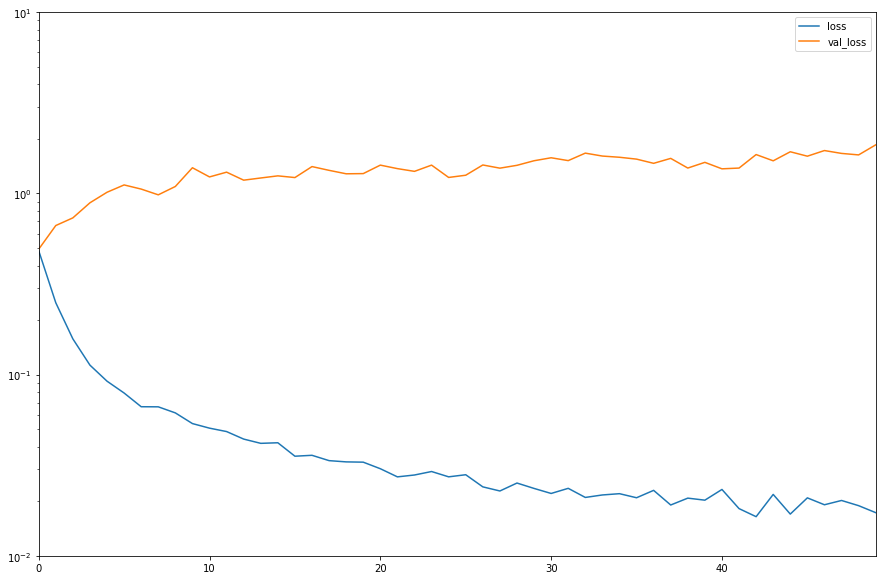

In [23]:
%matplotlib inline
import pandas as pd
pd.DataFrame(history.history)[["loss", "val_loss"]].plot(ylim=(1e-2, 1e+1), figsize=(15, 10), logy=True)

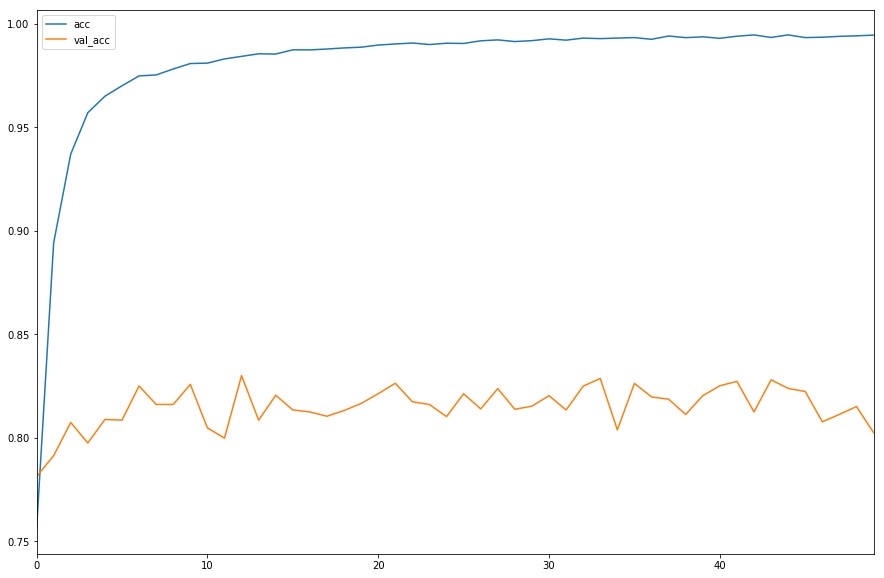

In [26]:
pd.DataFrame(history.history)[["acc", "val_acc"]].plot(figsize=(15, 10))

# VGG16が抽出した特徴を使って多層パーセプトロンを学習
- VGG16を特徴抽出器として使う手法
- 畳み込み層までを使ってFully Connected Layerは捨てる

In [13]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from os.path import join

model_dir = './models/'
train_data_dir = './data/train'
validation_data_dir = './data/validation'
img_width, img_height = 150, 150
train_steps = 2000
validation_steps = 800
epochs = 50

def save_bottleneck_features():
    """VGG16にDog vs Catの訓練画像、テスト画像を入力し、
    ボトルネック特徴量(FC層の直前の出力)をファイルに保存
    """
    
    # VGG16と学習済み重みをロード
    # Fully-Connected層(FC)層はいらないのでinclude_top=False
    model = VGG16(include_top=False, weights='imagenet')
    model.summary()
    
    # ジェネレータの設定
    datagen = ImageDataGenerator(rescale=1.0/255)
    
    # Dog vs Cat のトレーニングセットを生成するジェネレータを作成
    # 引用元ではbatch_size=32だが、そうするとdata.shape=(32x800, 4, 4, 512)となってしまい次元数が合わなくてエラーになってしまう。
    # そこをmodel.predict_generatorのsteps=800で解決するはずがされないので仕方なくbatch_size=1としている...
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode=None,
        shuffle=False)    
    # ジェネレータから生成される画像を入力し、VGG16の出力をファイルに保存
    bottleneck_features_train = model.predict_generator(generator, steps=train_steps)
    np.save(join(model_dir, 'bottleneck_features_train.npy'), bottleneck_features_train)
    
    # Dog vs Cat のバリデーションセットを生成するジェネレータを作成
    # 前述した理由によりbatch_size=32ではなく1にしている
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode=None,
        shuffle=False)
    # ジェネレータから生成される画像を入力し、VGG16の出力をファイルに保存
    bottleneck_features_validation = model.predict_generator(generator, steps=validation_steps)
    np.save(join(model_dir, 'bottleneck_features_validation.npy'), bottleneck_features_validation)
    
def train_top_model():
    """VGGのボトルネック特徴量を入力とし、 Dog vs Catの正解を出力とするFCネットワークを訓練
    """
    # 訓練データをロード
    # ジェネレータではshuffle=Falseなので最初の1000枚がcats, 次の1000枚がdogs
    train_data = np.load(join(model_dir, 'bottleneck_features_train.npy'))
    train_labels = np.array([0] * int(train_steps / 2) + [1] * int(train_steps / 2))
    
    # (2000, 4, 4, 512)
    print(train_data.shape)
    
    # バリデーションデータをロード
    validation_data = np.load(join(model_dir, 'bottleneck_features_validation.npy'))
    validation_labels = np.array([0] * int(validation_steps / 2) + [1] * int(validation_steps / 2))
    
    # (800, 4, 4, 512)
    print(validation_data.shape)
    
    # FCネットワークを構築
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
    
    history = model.fit(train_data, train_labels, epochs=epochs, batch_size=32, validation_data=(validation_data, validation_labels))
    
    model.save_weights(join(model_dir, 'bottleneck_fc_model.h5'))
    save_history(history, join(model_dir, 'history_extractor.txt'))

In [14]:
# 訓練データとバリデーションデータのボトルネック特徴量を抽出
save_bottleneck_features()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [15]:
# ボトルネック特徴量FCネットワークを学習
train_top_model()

(2000, 4, 4, 512)
(800, 4, 4, 512)
Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 0s - loss: 0.7322 - acc: 0.5600 - val_loss: 0.5677 - val_acc: 0.7562
Epoch 2/50
2000/2000 [==============================] - 0s - loss: 0.5851 - acc: 0.6855 - val_loss: 0.5140 - val_acc: 0.7937
Epoch 3/50
2000/2000 [==============================] - 0s - loss: 0.5202 - acc: 0.7455 - val_loss: 0.4704 - val_acc: 0.8237
Epoch 4/50
2000/2000 [==============================] - 0s - loss: 0.4879 - acc: 0.7745 - val_loss: 0.4444 - val_acc: 0.8225
Epoch 5/50
2000/2000 [==============================] - 0s - loss: 0.4620 - acc: 0.7895 - val_loss: 0.4227 - val_acc: 0.8550
Epoch 6/50
2000/2000 [==============================] - 0s - loss: 0.4373 - acc: 0.8120 - val_loss: 0.4035 - val_acc: 0.8400
Epoch 7/50
2000/2000 [==============================] - 0s - loss: 0.4232 - acc: 0.8115 - val_loss: 0.3906 - val_acc: 0.8413
Epoch 8/50
2000/2000 [=====================

# VGG16をFine-tuningする
- FC層だけでなくその１つ前の畳込み層の重みも少し学習する
- CNNでは浅い層ほどedgeやblobといった汎用的な特徴、深い層ほど学習データに特化した特徴が抽出される傾向にある
- 浅い層の汎用的な特徴抽出器はそのまま固定し(frozen)、深い層の重みのみ今回の犬・猫分類に合うように再調整することをFine-tuningと呼ぶ

In [32]:
from keras.layers import Input
from keras.models import Model

# VGG16モデルと学習済み重みをロード
# FC層はいらないのでinclude_top=False
# input_tensorを指定しておかないとoutput_shapeがNoneになってエラーになるので注意
# https://keras.io/applications/#inceptionv3
input_tensor = Input(shape=(150, 150, 3))
vgg16_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
# vgg16_model.summary()

# FC層を構築
# Flattenへの入力指定はバッチ数を除く
top_model = Sequential()
top_model.add(Flatten(input_shape=(vgg16_model.output_shape[1:])))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# 学習済みのFC層の重みをロード
top_model.load_weights(join(model_dir, 'bottleneck_fc_model.h5'))

# vgg16_modelはkeras.engine.training.Model
# top_modelはSequentialとなっている
# ModelはSequentialでないためadd()がない
# そのためFunctioal APIで２つのモデルを結合する
# https://github.com/fchollet/keras/issues/4040
model = Model(inputs=vgg16_model.input, outputs=top_model(vgg16_model.output))
print('vgg16_model:', vgg16_model)
print('top_model:', top_model)
print('model:', model)

# Total params: 16,812,353
# Trainable params: 16,812,353
# Non-trainable params: 0
model.summary()

# layerを表示
for i, layer in enumerate(model.layers):
    print(i, layer)
    
# 最後のConv層の直前までの層をFreeze
for layer in model.layers[:15]:
    layer.trainable = False

# trainableと合わせて確認
for i, layer in enumerate(model.layers):
    print(i, layer, layer.trainable)
    
# Total params: 16,812,353
# Trainable params: 9,177,089
# Non-trainable params: 7,635,264
model.summary()

# ここでadamを使うとうまくいかない
# Fine-tuningのときは学習率を小さくしたSGDの方がいい？
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

vgg16_model: <keras.engine.training.Model object at 0x7f1221ee4240>
top_model: <keras.models.Sequential object at 0x7f12223c5a20>
model: <keras.engine.training.Model object at 0x7f1221e47e48>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Co

In [35]:
steps_per_epoch = 2000
epochs = 50
validation_steps = 800

train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=32, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=32, class_mode='binary')

# Fine-tuning
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator, 
    validation_steps=800)

model.save_weights(join(model_dir, 'finetuning.h5'))
save_history(history, join(model_dir, 'history_finetuning.txt'))

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/50
2000/2000 [==============================] - 969s - loss: 0.1489 - acc: 0.9414 - val_loss: 0.1632 - val_acc: 0.9387
Epoch 2/50
2000/2000 [==============================] - 967s - loss: 0.0499 - acc: 0.9833 - val_loss: 0.1730 - val_acc: 0.9409
Epoch 3/50
2000/2000 [==============================] - 967s - loss: 0.0232 - acc: 0.9934 - val_loss: 0.1914 - val_acc: 0.9439
Epoch 4/50
2000/2000 [==============================] - 967s - loss: 0.0125 - acc: 0.9967 - val_loss: 0.2055 - val_acc: 0.9362
Epoch 5/50
2000/2000 [==============================] - 966s - loss: 0.0091 - acc: 0.9977 - val_loss: 0.2105 - val_acc: 0.9387
Epoch 6/50
2000/2000 [==============================] - 966s - loss: 0.0055 - acc: 0.9986 - val_loss: 0.2305 - val_acc: 0.9363
Epoch 7/50
2000/2000 [==============================] - 966s - loss: 0.0042 - acc: 0.9992 - val_loss: 0.2324 - val_acc: 0.9439
Epoch 8/50
2000/2000 [======

In [26]:
!ls models/

bottleneck_fc_model.h5		    history_finetuning.txt
bottleneck_features_train.npy	    history_smallcnn.txt
bottleneck_features_validation.npy  smallcnn_architecture.json
finetuning.h5			    smallcnn_weights.h5
history_extractor.txt


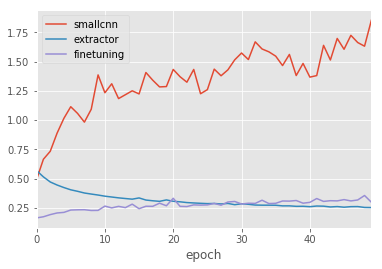

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd

pd.concat([
    pd.read_csv('./models/history_smallcnn.txt', sep='\t').set_index("epoch")[["val_loss"]].rename(columns={"val_loss":"smallcnn"}),
    pd.read_csv('./models/history_extractor.txt', sep='\t').set_index("epoch")[["val_loss"]].rename(columns={"val_loss":"extractor"}),
    pd.read_csv('./models/history_finetuning.txt', sep='\t').set_index("epoch")[["val_loss"]].rename(columns={"val_loss":"finetuning"}),
], axis=1).plot()

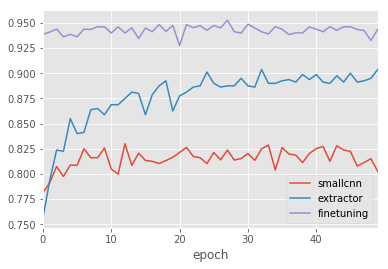

In [44]:
pd.concat([
    pd.read_csv('./models/history_smallcnn.txt', sep='\t').set_index("epoch")[["val_acc"]].rename(columns={"val_acc":"smallcnn"}),
    pd.read_csv('./models/history_extractor.txt', sep='\t').set_index("epoch")[["val_acc"]].rename(columns={"val_acc":"extractor"}),
    pd.read_csv('./models/history_finetuning.txt', sep='\t').set_index("epoch")[["val_acc"]].rename(columns={"val_acc":"finetuning"}),
], axis=1).plot()

# 犬と猫の分類
- 最も精度のよかったfinetuningモデルで実際に分類してみる
- kaggleに出す前の確認

In [121]:
from os.path import join
import sys
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
import numpy as np

model_dir = './models'
img_height, img_width = 150, 150
channels = 3

def load_finetuning_model():
    # VGG16
    input_tensor = Input(shape=(img_height, img_width, channels))
    vgg16_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

    # FC
    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    # VGG16とFCを接続
    model = Model(inputs=vgg16_model.input, outputs=top_model(vgg16_model.output))

    # 学習済みの重みをロード
    model.load_weights(join(model_dir, 'finetuning.h5'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = load_finetuning_model()

def predict_dog_or_cat(file_name):

#     model = load_finetuning_model()

    # model.summary()

    # 画像を読み込んで4次元Tensorへ変換
    img = image.load_img(file_name, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # 学習時にImageDataGeneratorのrescaleで正規化したので同じ処理が必要
    # これを忘れると結果がおかしくなるので注意
    x = x / 255.0

    # クラスを予測
    # 入力は1枚の画像なので[0]のみ
    return model.predict(x)[0]


from PIL import Image
import re
from urllib.request import urlopen
import base64
import requests
from io import BytesIO

url_to_b64 = lambda url: base64.b64encode(requests.get(url).content)

def to_pillow(image_path):
    if re.match("""^(http|https):""", image_path):
        return Image.open(BytesIO(urlopen(image_path).read()))
    else:
        return Image.open(image_path)

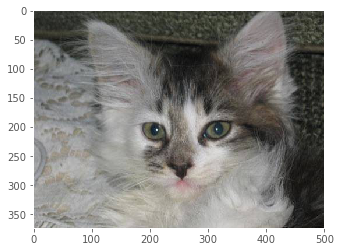

[  1.48323888e-11]
cat


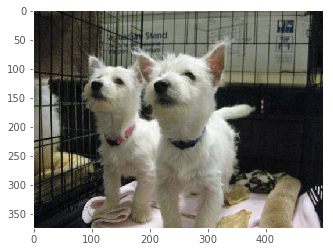

[ 0.99747145]
dog


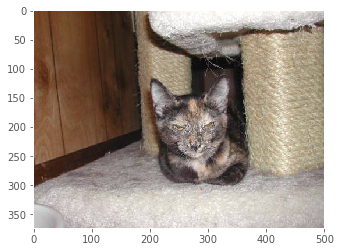

[  2.97697378e-09]
cat


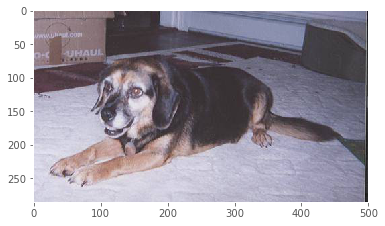

[ 1.]
dog


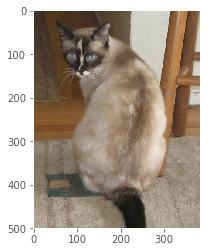

[  6.33280360e-05]
cat


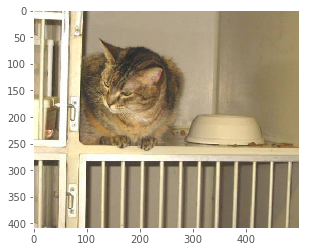

[  8.13375962e-08]
cat


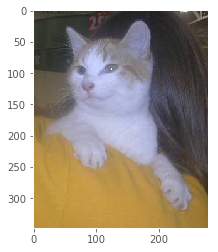

[  8.07220957e-10]
cat


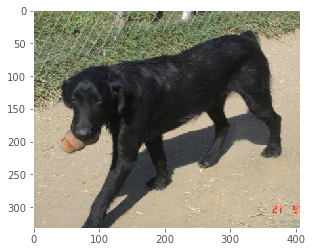

[ 1.]
dog


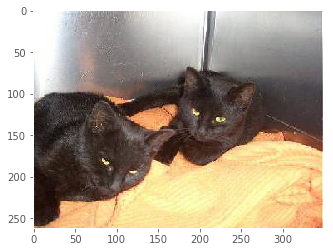

[  1.05689587e-07]
cat


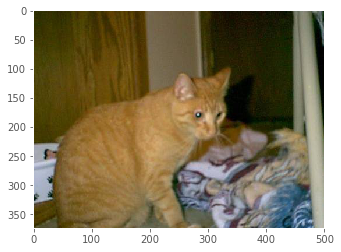

[  8.63841549e-08]
cat


In [123]:
cats_all = !ls data/validation/cats
dogs_all = !ls data/validation/dogs
cats_all = [join('data/validation/cats', path) for path in cats_all]
dogs_all = [join('data/validation/dogs', path) for path in dogs_all]

# 10枚適当に選んで作ったfinetuningモデルで分類してみる
for image_path in np.random.choice(cats_all + dogs_all, 10):
    x = np.array(to_pillow(image_path))
    plt.grid(False) 
    plt.imshow(x)
    plt.show()
    dog_rate = predict_dog_or_cat(image_path)
    print(dog_rate)
    if dog_rate >= 0.5:
        print("dog")
    else:
        print("cat")
    print("=====================================================")

In [105]:
prod_image_path = !ls data/production/
max([int(i.replace('.jpg', '')) for i in prod_image_path])

12500

In [135]:
pd.DataFrame([i for i in range(1, 12501)], columns=["id"]).assign(
    label=lambda df: df.apply(lambda df: predict_dog_or_cat("./data/production/{}.jpg".format(df.id)), axis=1)
).set_index("id").to_csv("./submission.csv")

In [136]:
!head submission.csv

id,label
1,1.0
2,1.0
3,1.0
4,1.0
5,5.900549493453866e-11
6,7.605785792841324e-12
7,9.341122148917124e-19
8,8.033608537516557e-06
9,2.431127868463001e-11
